In [1]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings

In [2]:
# ปิดการแจ้งเตือนค่าคงที่
warnings.filterwarnings("ignore")

In [3]:
# Set the display options to prevent line wrapping and truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [4]:
data = pd.read_csv(r"csv\dataset_malwares.csv")

X = data.drop(['Name','Malware','SuspiciousImportFunctions','SuspiciousNameSection','TimeDateStamp'], axis=1)
y = data['Malware']

In [5]:
models = MLPClassifier()

In [6]:
def info_gain(k_mins, k_maxs, X, y, model, seed, cv):

    k_min = k_mins
    k_max = k_maxs

    results = []
    k_values = []
    accuracy_values = []

    f = open(f"result_text/info_gain/Info_MLP_seed{seed}.txt", "w+")
    
    for k in range(k_min, k_max):

        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X, y)

        cols = selector.get_support(indices=True)

        X_select = X.iloc[:,cols]

        kf = KFold(n_splits=cv, random_state=seed, shuffle=True)

        scores = cross_val_score(model, X_select, y, cv=kf, scoring='accuracy')

        accuracy_score = scores.mean()

        k_values.append(k)
        accuracy_values.append(accuracy_score)
        results.append([k, accuracy_score])

        f.write('\n')
        f.write(f'ACC = {accuracy_score} K = {k} {X_select.columns.tolist()}')

    headers = ["K", "Accuracy"]
    f.write('\n')
    f.write(tabulate(results, headers, tablefmt="pretty"))
    f.close()

    plt.figure(figsize=(20, 6))
    plt.plot(k_values, accuracy_values, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title(f'Information Gain - MLP, seed = {seed}')
    plt.xticks(range(k_min, k_max))
    plt.grid(True)

    save_path = f"result_graph/info_gain/Info_MLP_seed{seed}"
    plt.savefig(save_path)
    plt.close()

    return k_values, accuracy_values, k_max, selector

In [7]:
def main():

    f = open(f"result_text/average_result/Info_MLP_seed1-100.txt", "w+")    
    all_accuracy_values = []

    for seeds in range(1, 3):
        k_vals, acc_vals, k_maxs, selectors = info_gain(k_mins=1, k_maxs=6, X=X, y=y, model=models, seed=seeds, cv=2)
        all_accuracy_values.append(acc_vals)

    all_accuracy_values_array = np.array(all_accuracy_values)

    average_accuracies = all_accuracy_values_array.mean(axis=0)

    features_score = pd.DataFrame(selectors.scores_)
    features = pd.DataFrame(X.columns)
    feature_score = pd.concat([features,features_score],axis=1)

    feature_score.columns = ["Input_Features","Score"]
    print(feature_score.nlargest(75,columns="Score"))
    f.write(feature_score.nlargest(75, columns="Score").to_string(index=False))

    average_results = list(zip(range(1, k_maxs + 1), average_accuracies))
    headers = ["K", "Average Accuracy 1-100 seed"]

    print('\n')
    print(tabulate(average_results, headers, tablefmt="pretty"))

    f.write('\n')
    f.write(tabulate(average_results, headers, tablefmt="pretty"))
    f.close()
    
    plt.figure(figsize=(20, 6))
    plt.plot(k_vals, average_accuracies, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Average Accuracy 1-100 seed')
    plt.title(f'Information Gain - MLP, Sample group 100 seeds')
    plt.xticks(range(1, k_maxs))
    plt.grid(True)
    save_path = f"result_graph/average_result/Info_MLP_seed1-100"
    plt.savefig(save_path)
    plt.show()

                  Input_Features     Score
44            DllCharacteristics  0.343883
22               Characteristics  0.337595
35   MinorOperatingSystemVersion  0.288773
37             MinorImageVersion  0.282732
31                     ImageBase  0.271437
38         MajorSubsystemVersion  0.269724
24            MajorLinkerVersion  0.263360
45            SizeOfStackReserve  0.256558
70     ImageDirectoryEntryImport  0.245575
34   MajorOperatingSystemVersion  0.236673
52             SectionMinEntropy  0.231790
39         MinorSubsystemVersion  0.231502
56         SectionMinVirtualsize  0.215472
43                     Subsystem  0.201133
41                      CheckSum  0.200594
58            SectionMaxPhysical  0.194181
29           AddressOfEntryPoint  0.183396
54             SectionMinRawsize  0.183022
27         SizeOfInitializedData  0.179157
69     ImageDirectoryEntryExport  0.153030
67      DirectoryEntryImportSize  0.138449
62         SectionMaxPointerData  0.135752
68         

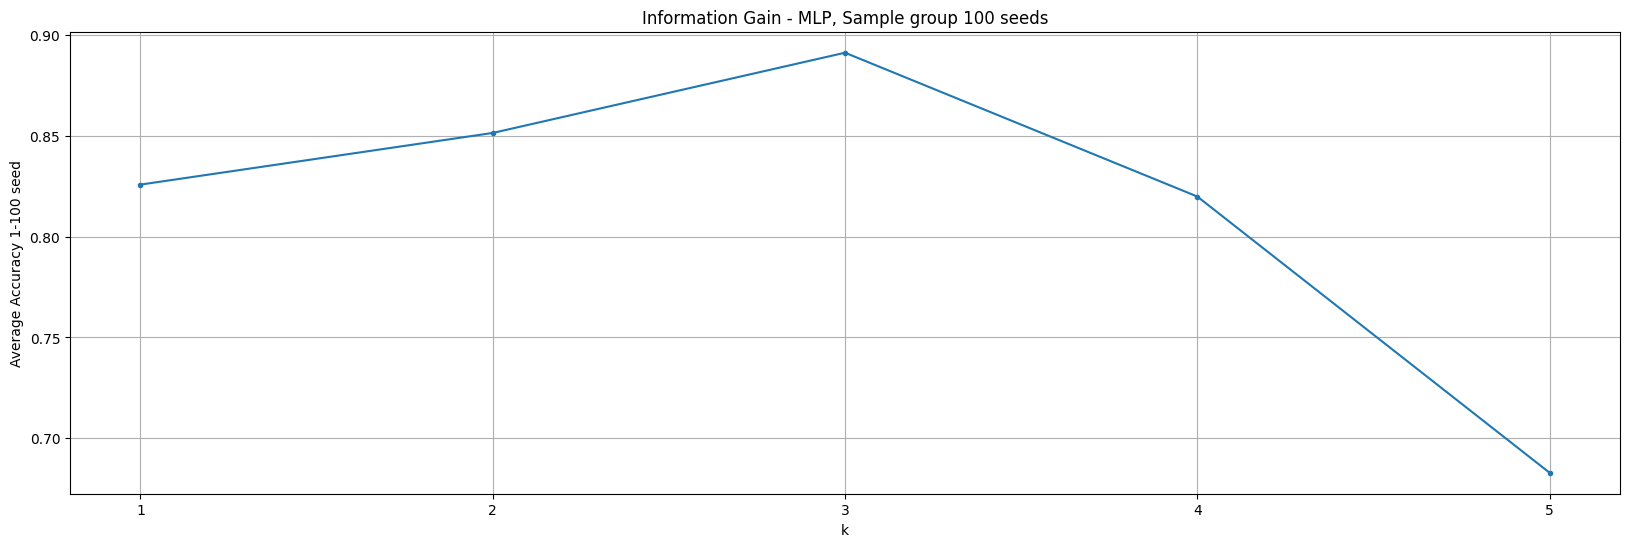

In [8]:
main()